In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kerne

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90)

100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [1/120], Step [219/219], Loss: 3.2265, Accuracy: 0.1007
Accuracy of the network: 0.098 Loss: 3.1080429959804454


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [2/120], Step [219/219], Loss: 2.7922, Accuracy: 0.1023
Accuracy of the network: 0.09066666666666667 Loss: 2.64614896064109


100%|██████████| 219/219 [01:10<00:00,  3.09it/s]


Epoch [3/120], Step [219/219], Loss: 2.5561, Accuracy: 0.1203
Accuracy of the network: 0.16666666666666666 Loss: 2.2410247148351465


100%|██████████| 219/219 [01:09<00:00,  3.14it/s]


Epoch [4/120], Step [219/219], Loss: 2.2583, Accuracy: 0.1560
Accuracy of the network: 0.14233333333333334 Loss: 2.410562558377043


100%|██████████| 219/219 [01:08<00:00,  3.21it/s]


Epoch [5/120], Step [219/219], Loss: 2.1657, Accuracy: 0.1723
Accuracy of the network: 0.198 Loss: 2.1320795733877955


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [6/120], Step [219/219], Loss: 2.1670, Accuracy: 0.1714
Accuracy of the network: 0.15666666666666668 Loss: 2.1094854169703545


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [7/120], Step [219/219], Loss: 2.1432, Accuracy: 0.1739
Accuracy of the network: 0.197 Loss: 2.0874975222222347


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [8/120], Step [219/219], Loss: 2.1155, Accuracy: 0.1843
Accuracy of the network: 0.191 Loss: 2.071103038940024


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [9/120], Step [219/219], Loss: 2.0954, Accuracy: 0.1919
Accuracy of the network: 0.19933333333333333 Loss: 2.07822064135937


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [10/120], Step [219/219], Loss: 2.0845, Accuracy: 0.2029
Accuracy of the network: 0.205 Loss: 2.07150817424693


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [11/120], Step [219/219], Loss: 2.0597, Accuracy: 0.2187
Accuracy of the network: 0.222 Loss: 2.0285409562131194


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [12/120], Step [219/219], Loss: 1.9957, Accuracy: 0.2386
Accuracy of the network: 0.26366666666666666 Loss: 1.936436967646822


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [13/120], Step [219/219], Loss: 1.9368, Accuracy: 0.2691
Accuracy of the network: 0.26366666666666666 Loss: 1.938038708047664


100%|██████████| 219/219 [01:09<00:00,  3.15it/s]


Epoch [14/120], Step [219/219], Loss: 1.9026, Accuracy: 0.2860
Accuracy of the network: 0.2673333333333333 Loss: 1.9015102056746787


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [15/120], Step [219/219], Loss: 1.9065, Accuracy: 0.2719
Accuracy of the network: 0.25466666666666665 Loss: 1.9096986968466576


100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [16/120], Step [219/219], Loss: 1.8957, Accuracy: 0.2769
Accuracy of the network: 0.274 Loss: 1.9094297708349024


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [17/120], Step [219/219], Loss: 1.8719, Accuracy: 0.2903
Accuracy of the network: 0.288 Loss: 1.87309341988665


100%|██████████| 219/219 [01:09<00:00,  3.14it/s]


Epoch [18/120], Step [219/219], Loss: 1.8653, Accuracy: 0.2929
Accuracy of the network: 0.292 Loss: 1.8686576992907422


100%|██████████| 219/219 [01:10<00:00,  3.09it/s]


Epoch [19/120], Step [219/219], Loss: 1.8633, Accuracy: 0.2919
Accuracy of the network: 0.272 Loss: 1.8762768722595053


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [20/120], Step [219/219], Loss: 1.8448, Accuracy: 0.2981
Accuracy of the network: 0.31266666666666665 Loss: 1.8488257387851148


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [21/120], Step [219/219], Loss: 1.8371, Accuracy: 0.3074
Accuracy of the network: 0.30466666666666664 Loss: 1.859235313344509


100%|██████████| 219/219 [01:09<00:00,  3.14it/s]


Epoch [22/120], Step [219/219], Loss: 1.8211, Accuracy: 0.3163
Accuracy of the network: 0.307 Loss: 1.8234718061508017


100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [23/120], Step [219/219], Loss: 1.7853, Accuracy: 0.3304
Accuracy of the network: 0.32466666666666666 Loss: 1.7878408888553052


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [24/120], Step [219/219], Loss: 1.7705, Accuracy: 0.3376
Accuracy of the network: 0.33266666666666667 Loss: 1.805120975413221


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [25/120], Step [219/219], Loss: 1.7482, Accuracy: 0.3550
Accuracy of the network: 0.3576666666666667 Loss: 1.7532968343572413


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [26/120], Step [219/219], Loss: 1.7288, Accuracy: 0.3619
Accuracy of the network: 0.3506666666666667 Loss: 1.7473276663333812


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [27/120], Step [219/219], Loss: 1.7198, Accuracy: 0.3681
Accuracy of the network: 0.3526666666666667 Loss: 1.7390508207869022


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [28/120], Step [219/219], Loss: 1.6945, Accuracy: 0.3774
Accuracy of the network: 0.36 Loss: 1.7290631190259407


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [29/120], Step [219/219], Loss: 1.6750, Accuracy: 0.3900
Accuracy of the network: 0.37366666666666665 Loss: 1.6998409540095227


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [30/120], Step [219/219], Loss: 1.6592, Accuracy: 0.3983
Accuracy of the network: 0.39166666666666666 Loss: 1.6708157531758572


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [31/120], Step [219/219], Loss: 1.6386, Accuracy: 0.3963
Accuracy of the network: 0.38533333333333336 Loss: 1.6707449048123462


100%|██████████| 219/219 [01:10<00:00,  3.13it/s]


Epoch [32/120], Step [219/219], Loss: 1.6193, Accuracy: 0.4103
Accuracy of the network: 0.40066666666666667 Loss: 1.6436036381315677


100%|██████████| 219/219 [01:03<00:00,  3.44it/s]


Epoch [33/120], Step [219/219], Loss: 1.6105, Accuracy: 0.4086
Accuracy of the network: 0.398 Loss: 1.6398701287330466


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [34/120], Step [219/219], Loss: 1.5835, Accuracy: 0.4201
Accuracy of the network: 0.3983333333333333 Loss: 1.6305432941051239


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [35/120], Step [219/219], Loss: 1.5754, Accuracy: 0.4263
Accuracy of the network: 0.40066666666666667 Loss: 1.6161366282625402


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [36/120], Step [219/219], Loss: 1.5628, Accuracy: 0.4309
Accuracy of the network: 0.418 Loss: 1.6005004441484492


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [37/120], Step [219/219], Loss: 1.5427, Accuracy: 0.4390
Accuracy of the network: 0.41133333333333333 Loss: 1.6129322939730706


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [38/120], Step [219/219], Loss: 1.5263, Accuracy: 0.4467
Accuracy of the network: 0.411 Loss: 1.5869238351253754


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [39/120], Step [219/219], Loss: 1.5241, Accuracy: 0.4461
Accuracy of the network: 0.42133333333333334 Loss: 1.5751792179777266


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [40/120], Step [219/219], Loss: 1.5103, Accuracy: 0.4520
Accuracy of the network: 0.42633333333333334 Loss: 1.568166210296306


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [41/120], Step [219/219], Loss: 1.5009, Accuracy: 0.4571
Accuracy of the network: 0.43466666666666665 Loss: 1.567338282757617


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [42/120], Step [219/219], Loss: 1.4911, Accuracy: 0.4594
Accuracy of the network: 0.438 Loss: 1.5541099817194837


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [43/120], Step [219/219], Loss: 1.4900, Accuracy: 0.4661
Accuracy of the network: 0.432 Loss: 1.5485662082408338


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [44/120], Step [219/219], Loss: 1.4696, Accuracy: 0.4744
Accuracy of the network: 0.442 Loss: 1.534846431397377


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [45/120], Step [219/219], Loss: 1.4596, Accuracy: 0.4677
Accuracy of the network: 0.42833333333333334 Loss: 1.5450386176718043


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [46/120], Step [219/219], Loss: 1.4636, Accuracy: 0.4759
Accuracy of the network: 0.446 Loss: 1.526217332545747


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [47/120], Step [219/219], Loss: 1.4611, Accuracy: 0.4717
Accuracy of the network: 0.44566666666666666 Loss: 1.5331054558145238


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [48/120], Step [219/219], Loss: 1.4422, Accuracy: 0.4827
Accuracy of the network: 0.4493333333333333 Loss: 1.5235411917909663


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [49/120], Step [219/219], Loss: 1.4453, Accuracy: 0.4799
Accuracy of the network: 0.45966666666666667 Loss: 1.510738214279743


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [50/120], Step [219/219], Loss: 1.4289, Accuracy: 0.4867
Accuracy of the network: 0.452 Loss: 1.5041244968454888


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [51/120], Step [219/219], Loss: 1.4252, Accuracy: 0.4874
Accuracy of the network: 0.4573333333333333 Loss: 1.4872218839665676


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [52/120], Step [219/219], Loss: 1.4188, Accuracy: 0.4821
Accuracy of the network: 0.4643333333333333 Loss: 1.5025939155132213


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [53/120], Step [219/219], Loss: 1.4076, Accuracy: 0.4971
Accuracy of the network: 0.45566666666666666 Loss: 1.4975964934267896


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [54/120], Step [219/219], Loss: 1.4062, Accuracy: 0.4961
Accuracy of the network: 0.44966666666666666 Loss: 1.4996458811962858


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [55/120], Step [219/219], Loss: 1.4042, Accuracy: 0.4946
Accuracy of the network: 0.45866666666666667 Loss: 1.486340655925426


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [56/120], Step [219/219], Loss: 1.3972, Accuracy: 0.4980
Accuracy of the network: 0.454 Loss: 1.48863840610423


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [57/120], Step [219/219], Loss: 1.3896, Accuracy: 0.4964
Accuracy of the network: 0.4603333333333333 Loss: 1.4832156237135543


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [58/120], Step [219/219], Loss: 1.3941, Accuracy: 0.4917
Accuracy of the network: 0.4663333333333333 Loss: 1.4860270226255377


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [59/120], Step [219/219], Loss: 1.3938, Accuracy: 0.5007
Accuracy of the network: 0.466 Loss: 1.4783476895474372


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [60/120], Step [219/219], Loss: 1.3796, Accuracy: 0.5056
Accuracy of the network: 0.4653333333333333 Loss: 1.490086924522481


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [61/120], Step [219/219], Loss: 1.3763, Accuracy: 0.5030
Accuracy of the network: 0.464 Loss: 1.4762721010979185


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [62/120], Step [219/219], Loss: 1.3784, Accuracy: 0.5013
Accuracy of the network: 0.4653333333333333 Loss: 1.471599188256771


100%|██████████| 219/219 [00:50<00:00,  4.38it/s]


Epoch [63/120], Step [219/219], Loss: 1.3807, Accuracy: 0.4991
Accuracy of the network: 0.4683333333333333 Loss: 1.4759428551856508


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [64/120], Step [219/219], Loss: 1.3778, Accuracy: 0.5074
Accuracy of the network: 0.47433333333333333 Loss: 1.473942293765697


100%|██████████| 219/219 [00:49<00:00,  4.43it/s]


Epoch [65/120], Step [219/219], Loss: 1.3872, Accuracy: 0.4969
Accuracy of the network: 0.47533333333333333 Loss: 1.4701630542887019


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [66/120], Step [219/219], Loss: 1.3699, Accuracy: 0.5004
Accuracy of the network: 0.474 Loss: 1.4695501200696255


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [67/120], Step [219/219], Loss: 1.3705, Accuracy: 0.5053
Accuracy of the network: 0.468 Loss: 1.4743474747272247


100%|██████████| 219/219 [00:49<00:00,  4.42it/s]


Epoch [68/120], Step [219/219], Loss: 1.3605, Accuracy: 0.5127
Accuracy of the network: 0.474 Loss: 1.4647145157164716


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [69/120], Step [219/219], Loss: 1.3611, Accuracy: 0.5166
Accuracy of the network: 0.474 Loss: 1.4612230912167976


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [70/120], Step [219/219], Loss: 1.3577, Accuracy: 0.5131
Accuracy of the network: 0.4723333333333333 Loss: 1.46374163982716


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [71/120], Step [219/219], Loss: 1.3630, Accuracy: 0.5116
Accuracy of the network: 0.47333333333333333 Loss: 1.457962712074848


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [72/120], Step [219/219], Loss: 1.3649, Accuracy: 0.5061
Accuracy of the network: 0.47333333333333333 Loss: 1.4576334636262123


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [73/120], Step [219/219], Loss: 1.3470, Accuracy: 0.5206
Accuracy of the network: 0.4816666666666667 Loss: 1.4546788867483749


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [74/120], Step [219/219], Loss: 1.3635, Accuracy: 0.5084
Accuracy of the network: 0.479 Loss: 1.4554551446691473


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [75/120], Step [219/219], Loss: 1.3605, Accuracy: 0.5083
Accuracy of the network: 0.484 Loss: 1.4545066128385828


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [76/120], Step [219/219], Loss: 1.3540, Accuracy: 0.5184
Accuracy of the network: 0.476 Loss: 1.462187097427693


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [77/120], Step [219/219], Loss: 1.3558, Accuracy: 0.5167
Accuracy of the network: 0.47433333333333333 Loss: 1.456732006783181


100%|██████████| 219/219 [00:50<00:00,  4.29it/s]


Epoch [78/120], Step [219/219], Loss: 1.3553, Accuracy: 0.5153
Accuracy of the network: 0.47833333333333333 Loss: 1.455545131196367


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [79/120], Step [219/219], Loss: 1.3490, Accuracy: 0.5210
Accuracy of the network: 0.473 Loss: 1.4688230410535286


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [80/120], Step [219/219], Loss: 1.3497, Accuracy: 0.5163
Accuracy of the network: 0.47833333333333333 Loss: 1.4613838665028835


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [81/120], Step [219/219], Loss: 1.3541, Accuracy: 0.5163
Accuracy of the network: 0.475 Loss: 1.4516863746845976


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [82/120], Step [219/219], Loss: 1.3500, Accuracy: 0.5123
Accuracy of the network: 0.4776666666666667 Loss: 1.4467555779091856


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [83/120], Step [219/219], Loss: 1.3463, Accuracy: 0.5171
Accuracy of the network: 0.4736666666666667 Loss: 1.454409234067227


100%|██████████| 219/219 [00:58<00:00,  3.77it/s]


Epoch [84/120], Step [219/219], Loss: 1.3429, Accuracy: 0.5130
Accuracy of the network: 0.478 Loss: 1.450212609894732


100%|██████████| 219/219 [01:03<00:00,  3.42it/s]


Epoch [85/120], Step [219/219], Loss: 1.3491, Accuracy: 0.5186
Accuracy of the network: 0.47533333333333333 Loss: 1.4539334520380547


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [86/120], Step [219/219], Loss: 1.3481, Accuracy: 0.5190
Accuracy of the network: 0.4736666666666667 Loss: 1.4567330898122584


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [87/120], Step [219/219], Loss: 1.3564, Accuracy: 0.5127
Accuracy of the network: 0.481 Loss: 1.4526482604919595


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [88/120], Step [219/219], Loss: 1.3497, Accuracy: 0.5143
Accuracy of the network: 0.475 Loss: 1.4564962450494157


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [89/120], Step [219/219], Loss: 1.3501, Accuracy: 0.5191
Accuracy of the network: 0.4796666666666667 Loss: 1.4523994808501386


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [90/120], Step [219/219], Loss: 1.3382, Accuracy: 0.5240
Accuracy of the network: 0.48033333333333333 Loss: 1.4502440627585067


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [91/120], Step [219/219], Loss: 1.3443, Accuracy: 0.5204
Accuracy of the network: 0.478 Loss: 1.4481587448018662


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [92/120], Step [219/219], Loss: 1.3508, Accuracy: 0.5147
Accuracy of the network: 0.478 Loss: 1.4571919263677393


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [93/120], Step [219/219], Loss: 1.3467, Accuracy: 0.5150
Accuracy of the network: 0.483 Loss: 1.4509009046757475


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]


Epoch [94/120], Step [219/219], Loss: 1.3475, Accuracy: 0.5191
Accuracy of the network: 0.48133333333333334 Loss: 1.454058644619394


100%|██████████| 219/219 [01:12<00:00,  3.01it/s]


Epoch [95/120], Step [219/219], Loss: 1.3577, Accuracy: 0.5146
Accuracy of the network: 0.482 Loss: 1.4482766478619677


100%|██████████| 219/219 [01:14<00:00,  2.94it/s]


Epoch [96/120], Step [219/219], Loss: 1.3421, Accuracy: 0.5176
Accuracy of the network: 0.478 Loss: 1.45707849492418


100%|██████████| 219/219 [01:12<00:00,  3.02it/s]


Epoch [97/120], Step [219/219], Loss: 1.3381, Accuracy: 0.5206
Accuracy of the network: 0.4816666666666667 Loss: 1.4587570137165962


100%|██████████| 219/219 [01:13<00:00,  2.99it/s]


Epoch [98/120], Step [219/219], Loss: 1.3529, Accuracy: 0.5117
Accuracy of the network: 0.4806666666666667 Loss: 1.446592242159742


100%|██████████| 219/219 [01:13<00:00,  2.97it/s]


Epoch [99/120], Step [219/219], Loss: 1.3457, Accuracy: 0.5237
Accuracy of the network: 0.476 Loss: 1.4489133269228833


100%|██████████| 219/219 [01:12<00:00,  3.00it/s]


Epoch [100/120], Step [219/219], Loss: 1.3408, Accuracy: 0.5201
Accuracy of the network: 0.4703333333333333 Loss: 1.4611403751880565


100%|██████████| 219/219 [01:12<00:00,  3.00it/s]


Epoch [101/120], Step [219/219], Loss: 1.3416, Accuracy: 0.5226
Accuracy of the network: 0.4726666666666667 Loss: 1.456538234619384


100%|██████████| 219/219 [01:14<00:00,  2.93it/s]


Epoch [102/120], Step [219/219], Loss: 1.3418, Accuracy: 0.5177
Accuracy of the network: 0.477 Loss: 1.4590267944843212


100%|██████████| 219/219 [01:14<00:00,  2.95it/s]


Epoch [103/120], Step [219/219], Loss: 1.3514, Accuracy: 0.5097
Accuracy of the network: 0.4796666666666667 Loss: 1.4512561191903783


100%|██████████| 219/219 [01:13<00:00,  2.97it/s]


Epoch [104/120], Step [219/219], Loss: 1.3397, Accuracy: 0.5216
Accuracy of the network: 0.47633333333333333 Loss: 1.4514246373734576


100%|██████████| 219/219 [01:13<00:00,  2.98it/s]


Epoch [105/120], Step [219/219], Loss: 1.3376, Accuracy: 0.5203
Accuracy of the network: 0.4806666666666667 Loss: 1.4527917859402109


100%|██████████| 219/219 [01:18<00:00,  2.78it/s]


Epoch [106/120], Step [219/219], Loss: 1.3420, Accuracy: 0.5226
Accuracy of the network: 0.4776666666666667 Loss: 1.4563938975334167


100%|██████████| 219/219 [01:16<00:00,  2.85it/s]


Epoch [107/120], Step [219/219], Loss: 1.3534, Accuracy: 0.5136
Accuracy of the network: 0.481 Loss: 1.44487774752556


100%|██████████| 219/219 [01:14<00:00,  2.93it/s]


Epoch [108/120], Step [219/219], Loss: 1.3462, Accuracy: 0.5201
Accuracy of the network: 0.4796666666666667 Loss: 1.450976383178792


100%|██████████| 219/219 [01:12<00:00,  3.03it/s]


Epoch [109/120], Step [219/219], Loss: 1.3394, Accuracy: 0.5226
Accuracy of the network: 0.47633333333333333 Loss: 1.4519704390079418


100%|██████████| 219/219 [01:12<00:00,  3.02it/s]


Epoch [110/120], Step [219/219], Loss: 1.3466, Accuracy: 0.5159
Accuracy of the network: 0.4826666666666667 Loss: 1.4502090494683448


100%|██████████| 219/219 [01:14<00:00,  2.94it/s]


Epoch [111/120], Step [219/219], Loss: 1.3480, Accuracy: 0.5177
Accuracy of the network: 0.483 Loss: 1.4459054153016273


100%|██████████| 219/219 [01:13<00:00,  2.97it/s]


Epoch [112/120], Step [219/219], Loss: 1.3394, Accuracy: 0.5210
Accuracy of the network: 0.48233333333333334 Loss: 1.4549697650239823


100%|██████████| 219/219 [01:14<00:00,  2.94it/s]


Epoch [113/120], Step [219/219], Loss: 1.3370, Accuracy: 0.5230
Accuracy of the network: 0.479 Loss: 1.447780541917111


100%|██████████| 219/219 [01:12<00:00,  3.02it/s]


Epoch [114/120], Step [219/219], Loss: 1.3358, Accuracy: 0.5166
Accuracy of the network: 0.4816666666666667 Loss: 1.4568489346098392


100%|██████████| 219/219 [01:13<00:00,  2.98it/s]


Epoch [115/120], Step [219/219], Loss: 1.3424, Accuracy: 0.5154
Accuracy of the network: 0.4796666666666667 Loss: 1.4510527227787262


100%|██████████| 219/219 [01:14<00:00,  2.95it/s]


Epoch [116/120], Step [219/219], Loss: 1.3465, Accuracy: 0.5177
Accuracy of the network: 0.482 Loss: 1.4506160363237908


100%|██████████| 219/219 [01:13<00:00,  2.96it/s]


Epoch [117/120], Step [219/219], Loss: 1.3414, Accuracy: 0.5159
Accuracy of the network: 0.4756666666666667 Loss: 1.4572527751009514


100%|██████████| 219/219 [01:15<00:00,  2.91it/s]


Epoch [118/120], Step [219/219], Loss: 1.3336, Accuracy: 0.5236
Accuracy of the network: 0.48233333333333334 Loss: 1.4496748231826944


100%|██████████| 219/219 [01:13<00:00,  2.98it/s]


Epoch [119/120], Step [219/219], Loss: 1.3513, Accuracy: 0.5213
Accuracy of the network: 0.485 Loss: 1.4529961157352367


100%|██████████| 219/219 [00:55<00:00,  3.95it/s]


Epoch [120/120], Step [219/219], Loss: 1.3533, Accuracy: 0.5144
Accuracy of the network: 0.4836666666666667 Loss: 1.4481651110852019


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug.pt")

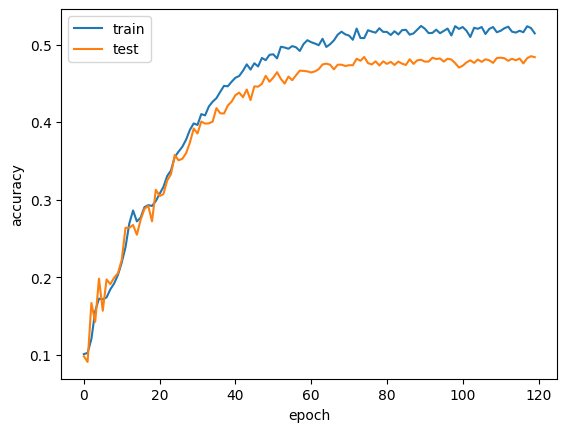

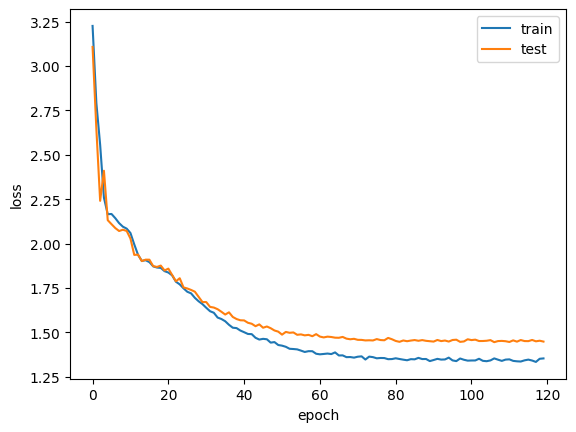

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.100714,0.098000,3.226458,3.108043
1,0.102286,0.090667,2.792172,2.646149
2,0.120286,0.166667,2.556119,2.241025
3,0.156000,0.142333,2.258346,2.410563
4,0.172286,0.198000,2.165710,2.132080
